In [1]:
n = 144
# DataLoader-ს წინასწარ უნდა ვუთხრათ batch-ების ზომა რომელსაც სწავლებისას ვიხმართ
# რადგან ჩვენ გადასწავლებას ვახდენთ, პატარა რიცხვიც კმარა (როგორიცაა 16)
batch_size = 16
# ვთ. გვაქვს 5 ეპოქა. თითო ეპოქაში დასასწავლ მონაცემებიდან ყველას
# ერთხელ მაინც ექნება საშუალება რომ გავლენა იქონიოს ქსელის პარამეტრების ცვლილებაზე
epochs = 5
# n-ის რამდენი პროცენტი არის ვალიდაციისთვის
val_size=0.1
label_number = 2


transformer_name = 'bert-base-multilingual-cased'

In [2]:
### მოგვაქვს მონაცემები სერვერიდან

import urllib.request, json, csv
import pandas as pd


with urllib.request.urlopen("https://neural-network123.herokuapp.com/get_items") as url:
    obj = json.loads(url.read().decode())

# ამივიღოთ ობიექტიდან ლისტი
sentence_list = obj["collection"]

# წავშალოთ თითო dictionary-ს _id ატრიბუტი
for i in range(len(sentence_list)):
  sentence_list[i].pop("_id",None);


print(sentence_list)

# ცარიელების მოშორება
temp = []
for i in range(len(sentence_list)):
  if sentence_list[i]["text"] != "":
    temp.append(sentence_list[i])

sentence_list = temp


# დუპლიკატების გაფილტრვა
temp = []
seen_sentences = set()
for i in range(len(sentence_list)):
  if sentence_list[i]["text"] not in seen_sentences:
    temp.append(sentence_list[i])
  seen_sentences.add(sentence_list[i]["text"])

sentence_list = temp

# ინგლისური წინადადებების გაწმინდვა
temp = []
for i in range(len(sentence_list)):
  if sentence_list[i]["text"].isascii():
    continue
  else:
    temp.append(sentence_list[i])

sentence_list = temp



field_names = ["text","label"]

with open('labeled_sentences.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(sentence_list)

df = pd.read_csv("./labeled_sentences.csv")

# არასწორი სვეტის სახელი გვაქვს ბაზაში, გადავარქვათ
df = df.rename(columns={"text":"sentence"})

# df = pd.DataFrame(sentence_list,columns=field_names)
 




In [3]:
import tensorflow as tf
# მივიღოთ GPU-ს სახელი
device_name = tf.test.gpu_device_name()
# დავაფორმატოთ output-ი
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch
# თუ GPU ნაპოვნია
if torch.cuda.is_available():    
    # ვუბრძანოთ pytorch-ს რომ გამოიყენოს იგი    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
!pip install transformers==3.0.0

In [6]:
!pip install wget
import wget
import os

# ცალ-ცალკე მასივებში ჩავსვათ წინადადებები და მათი კლასები
sentences = df.sentence.values
labels = df.label.values

In [7]:
from transformers import BertTokenizer
# ჩამოვტვირთოთ BERT-ის ტოკენიზატორი.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(transformer_name)

Loading BERT tokenizer...


In [8]:
# მოვახდინოთ ყველა წინადადების ტოკენიზაცია და ავსახოთ მათი ტოკენი სიტყვის ID-ში
input_ids = []

for sent in sentences:
    # `encode` ფუნქცია იზამს შემდეგს:
    #   (1) მოახდენს წინადადების ტოკენიზაციას
    #   (2) დასაწყისში  `[CLS]` ტოკენს ჩასვამს
    #   (3) ბოლოში მიადგამს `[SEP]` ტოკენს.
    #   (4) ასახავს ტოკენს თავის ID-ში
    encoded_sent = tokenizer.encode(
                        sent,                      # დასამუშავებელი წინადადება
                        add_special_tokens = True, # ჩაამატე '[CLS]' და '[SEP]'
                   )
    
    # დამუშავებული წინადადებები ჩავამატოთ სიაში
    input_ids.append(encoded_sent)

# დავბეჭდოთ მენულე წინადადება ახლა უკვე როგორც ID-ების სია.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  დღეს ოთხშაბათია? ჩემო მეგობარო
Token IDs: [101, 1567, 73685, 1577, 13900, 76564, 79194, 28848, 28305, 11577, 136, 1589, 17076, 48851, 68662, 73723, 28848, 28068, 102]


In [9]:
# ვიხმაროთ keras-ის დამხმარე ფუნქცია `pad_sequences` რომ ყველა სიას იგივე ზომა მივცეთ
from keras.preprocessing.sequence import pad_sequences
 
# დავაწესოთ წინადადების მაქსიმალური სიგრძე (სიტყვაზე 120)
MAX_LEN = 120
 
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# [PAD] ტოკენის ID არის 0, ამიტომ შევავსოთ ყველა სია 120 სიგრძემდე 0-ებით
# "post" ანიშნებს, რომ [PAD] ტოკენები გვინდა ჩავსვათ სიის ბოლოში და არა თავში
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.\n\n')
 
print("Example: \n\n\n",input_ids[0])


Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0
\Done.


Example: 


 [  101  1567 73685  1577 13900 76564 79194 28848 28305 11577   136  1589
 17076 48851 68662 73723 28848 28068   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [10]:
# შევქმნათ სია, რომელშიც გვექნება ყველა წინადადების ყურადღების mask-ები
attention_masks = []

for sent in input_ids:
    
    # შევქმნათ ყურადღების mask-ი:
    #   თუ ტოკენის ID არის 0, მაშინ [PAD] ტოკენი ყოფილა და mask არის 0
    #   თუ ტოკენის ID არის  > 0, მაშინ არაა [PAD] ტოკენი და mask არის 1
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

In [11]:
# ვიხმაროთ train_test_split რომ დავყოთ წინადადებები დასასწავლ და გასატესტ ნაწილებად
from sklearn.model_selection import train_test_split
# ვიხმაროთ 90% სწავლებისთვის და 10% ვალიდაციისთვის მაგალითად
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2021, test_size=val_size)
# იგივე ვქნათ mask-ებისთვის
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2021, test_size=val_size)

In [12]:
# ყველაფერი ვაქციოთ pytorch-ის ტენზორებად (სწავლებისთვის საჭიროა)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
 
# შევქმნათ DataLoader-ი დასასწავლი წინადადებებისთვის
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
 
# შევქმნათ DataLoader-ი გასატესტი წინადადებებისთვის
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# ჩამოვტვირთოთ BertForSequenceClassification, წინასწარ ნასწავლი BERT-ის მოდელი
# რომელსაც თავზე აქვს მიდგმული კლასიფიქატორი ქსელი
 
model = BertForSequenceClassification.from_pretrained(
    transformer_name,
    num_labels = label_number, # კლასების რაოდენობა - ჯერჯერობით 2 კლასი გვაქვს   
    output_attentions = False, # არ დავაბრუნოთ attention weight-ები
    output_hidden_states = False, # არ დავაბრუნოთ ფარული მეხსიერება
)
# ვიხმაროთ GPU გამოთვლებისთვის
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )
from transformers import get_linear_schedule_with_warmup
 

# total_steps = batches * epochs, სადაც batch არის დასასწავლ მონაცემთა რაღაც ქვესიმრავლე
# რომელზეც ეპოქის დროს ისწავლის ქსელი
total_steps = len(train_dataloader) * epochs
 
# scheduler განსაზღვრავს სწავლების თანმიმდევრობას
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [16]:
import numpy as np

# დამხმარე ფუნქცია რომელიც დაითვლის წინასწარმეტყველების სიზუსტეს label-ებთან შედარებით
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    იღებს დროს წამებში და აბრუნებს string-ს hh:mm:ss ფორმატში
    '''
    # დავამრგვალოთ ქვემოთ უახლოეს წამამდე
    elapsed_rounded = int(round((elapsed)))
    
    # დავაფორმატოთ როგორც hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
import random
import numpy as np
 
 
# ფსევდოშემთხვევითი რიცხვების გენერაციის დათესვა
seed_val = 42
 
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
 
# ამ ცვლადში ვინახავთ შემდეგ სიდიდეებს: გაწრთვნის და ვალიდაციის ცდომილებას,
# ვალიდაციის სიზუსტეს და დროებს
training_stats = []
 
# სრული დრო გაწრთვნის
total_t0 = time.time()
 
# გადავყვეთ ყველა ეპოქას
for epoch_i in range(0, epochs):
    
    # ========================================
    #               წრთვნა
    # ========================================
    
    # ერთხელ გადავყვეთ training set-ს ამ ეპოქაში
 
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
 
    # ამ ეპოქის წრთვნის დრო
    t0 = time.time()
 
    # განვაახლოთ ცდომილება ამ ეპოქისთვის
    total_train_loss = 0
 
 
    # მოდელს ჩავურთოთ წრთვნის რეჟიმი (ჯერ წრთვნა არ მიმდინარეობს)
    model.train()
 
    # გადავყვეთ batch-ებს
    for step, batch in enumerate(train_dataloader):
 
        # ყოველ 40 batch-ში დავბეჭდოთ პროგრესი
        if step % 40 == 0 and not step == 0:
            # გასული დრო წუთებში
            elapsed = format_time(time.time() - t0)
            
            # პროგრესი
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
 
        # ამოვიღოთ ეს დასასწავლი batch-ი dataloader-დან და
        # გადავცეთ მისი ტენზორები GPU-ს `to` მეთოდით
        #
        #
        #
        #
        # `batch`-ში არის 3 pytorch-ის ტენზორი:
        #   [0]: input id-ები
        #   [1]: ყურადღების მასკები
        #   [2]: label-ები
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
 
        # გავწმინდოთ წინა იტერაციის მიერ დათვლილი გრადიენტი
        model.zero_grad()        
 
        # დავასწავლოთ მოდელი ამ batch-ზე. model ფუნქცია აბრუნებს ცდომილებას და logit-ებს,
        # მოდელის output-ები სანამ მათი ნორმალიზაცია მოხდებოდა
        # https://developers.google.com/machine-learning/glossary/#logits
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
 
 
        # ავჯამოთ ცდომილებები ყველა batch-იდან. loss არის ერთ ელემენტიანი ტენზორი
        # item() ფუნქცია აბრუნებს ამ ელემენტს
        total_train_loss += loss.item()
 
        # უკუგავრცელება (დავითვალოთ გრადიენტები)
        loss.backward()
 
        # გავაკეთოთ ე.წ. gradient clipping, ანუ თუ გრადიენტმა გადააჭარბა
        # 1.0-ს, მოვახდინოთ მისი ნორმირება, რიომ შემცირდეს. საჭიროა
        # "exploding gradients" problem-ის თავიდან ასაცილებლად
        # https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
 
        # განვაახლოთ ქსელის პარამეტრები გამოთვლილი გრადიენტით და გადავდგათ
        # ნაბიჯი (step). თუ როგორ განახლდება პარამეტრები, ამას განსაზღვრავს
        # ოპტიმიზატორი AdamWest
        optimizer.step()
 
        # ასევე განვაახლოთ სწავლების სიჩქარე (ნაბიჯი == სწავლების სიჩქარე * გრადიენტი)
        scheduler.step()
 
 
    # დავითვალოთ საშუალო ცდომილება ყველა batch-ში
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # გავზომოთ თუ რა დრო მოუნდა ამ ეპოქას
    training_time = format_time(time.time() - t0)
 
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               ვალიდაცია
    # ========================================
    # ყოველი ეპოქის შემდეგ, დავითვალოთ ქსელის ეფექტურობა ვალიდაციის
    # სიმრავლეზე
 
    print("")
    print("Running Validation...")
 
    t0 = time.time()
 
    # მოდელი გავუშვათ evaluation რეჟიმში
    model.eval()
 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
 
    # გავაკეთოთ ვალიდაცია ამ ეპოქაზე
    for batch in validation_dataloader:
        
        # ამოვიღოთ batch-ი validation_dataloader-დან
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # ვუთხრათ pytorch-ს რომ არ გამოითვალოს გრადიენტი, რადგან მისი
        # გამოთვლა მხოლოდ სწავლებისას არის საჭირო
        with torch.no_grad():        
 
 
            # logit-ები არის ქსელის გამომავალი მნიშვნელობები, სანამ ისინი აქტივაციის ფუნქციაში
            # (მაგ. softmax-ში) ჩაისმებოდნენ და ნორმალიზდებოდნენ
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # ავჯამოთ ვალიდაციის ცდომილება
        total_eval_loss += loss.item()
 
        # გადავიტანოთ logits-ები და label-ები cpu-ში
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
 
 
        # დავითვალოთ ამ სატესტო წინადადებების batch-ის სიზუსტე
        # და ავჯამოთ ეს სიზუსტეები ყველა batch-ისთვის
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
 
    # ამ ვალიდაციის დავბეჭდოთ საბოლოო სიზუსტე
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
 
    # batch-ის საშუალო ცდომილება ყველა
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # რამდენი ხანი დასჭირდა ვალიდაციას
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
 
    # ჩავინიშნოთ ამ ვალიდაციის ყველა მონაცემი
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
 
print("")
print("Training complete!")
 
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.58
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.44
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.37
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.38
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.27
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.34
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.23
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.31
  Validation took: 0:00:00

Training complete!


In [19]:
import pandas as pd

# მძიმის შემდეგ 2 ციფრის სიზუსტიდ ამოვწეროთ
pd.set_option('precision', 2)

# შევქმნათ pandas-ის DataFrame ჩვენი სწავლების სტატისტიკებიდან
df_stats = pd.DataFrame(data=training_stats)

# გამოვიყენოთ ეპოქა როგორც ინდექსი
df_stats = df_stats.set_index('epoch')

# დავბეჭდოთ DataFrame
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.67,0.58,0.81,0:00:03,0:00:00
2,0.46,0.44,0.75,0:00:03,0:00:00
3,0.37,0.38,0.81,0:00:03,0:00:00
4,0.27,0.34,0.88,0:00:03,0:00:00
5,0.23,0.31,0.94,0:00:03,0:00:00


# შედეგების ვიზუალიზაცია

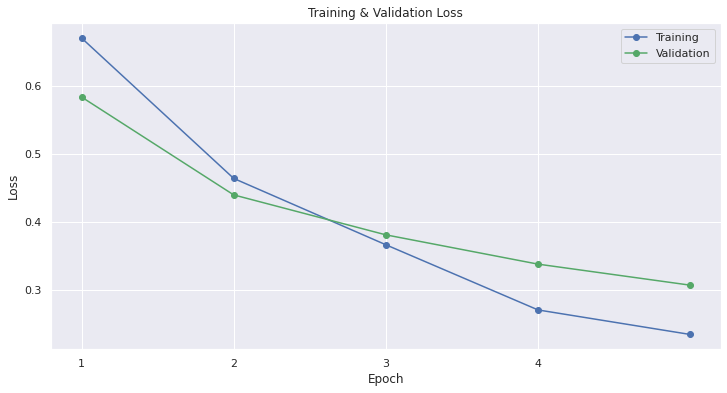

In [20]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# seaborn ბიბლიოთეკით გალამაზება
sns.set(style='darkgrid')

# ზომა და ფონტის ზომა
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12,6)

# დავხატოთ სწავლების გრაფიკი
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# ღერძებს დავარქვათ სახელები
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,epochs))

plt.show()

No handles with labels found to put in legend.


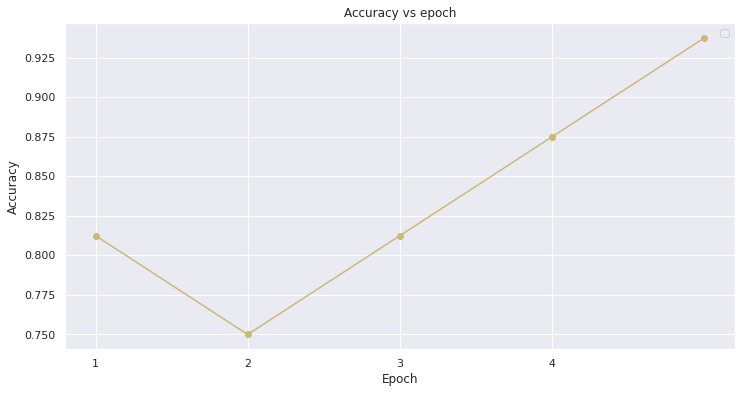

In [21]:
# სიზუსტის გრაფიკი
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Valid. Accur.'], 'y-o')


plt.title("Accuracy vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1,epochs))

plt.show()

In [22]:
import pandas as pd

df = pd.read_csv("labeled_sentences_test.csv")
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # წინადადება რომლის ენკოდინგიც გვინდა
                        add_special_tokens = True, # დაამატოს '[CLS]' და '[SEP]' ტოკენები
                        max_length = 64,           # გააკეთოს პადინგი და დიდ წინადადებებს ჩამოაჭრას ბოლოები
                        pad_to_max_length = True,
                        return_attention_mask = True,   # შექმნას ყურადღების masks-ები
                        return_tensors = 'pt',     # დააბრუნოს pytorch-ის ტენზორები
                        truncation=True,
                   )
    

    input_ids.append(encoded_dict['input_ids'])
    

    attention_masks.append(encoded_dict['attention_mask'])

# ვაქციოთ სიები ტენზორებად
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

 
batch_size = 32  

# DataLoader შევქმნათ
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 10



In [23]:
# სატესტო სიმრავლეზე გავაკეთოთ წინასწარმეტყველება

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# evaluation რეჟიმი
model.eval()


predictions , true_labels = [], []

# წინასწასწარმეტყველება batch-ებზე
for batch in prediction_dataloader:
  # GPU-ში ჩავსვათ batch-ი
  batch = tuple(t.to(device) for t in batch)
  
  # ამოვიღოთ მონაცემები batch-დან
  b_input_ids, b_input_mask, b_labels = batch
  
  # არ დავითვალოთ გრადიენტი რადგან სწავლება არ მიმდინარეობს (ოპტიმიზაცია)
  with torch.no_grad():
      # გამოვითვალოთ logit-ები
      # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  

  logits = outputs[0]

  # გადავიტანოთ logit-ები და labelები CPU-ში
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # დავიმახსოვროთ logit-ები და სწორი კლასები
  predictions.append(logits)
  true_labels.append(label_ids)

# ამაზე მოქმედებს softmax, ანუ ორი რიცხვიდან უდიდესის ინდექსს ირჩევს კლასად!
print(predictions)

# ჭეშმარიტი კლასები
print(true_labels)

print('    DONE.')

Predicting labels for 10 test sentences...
[array([[ 1.6946076 , -0.49069646],
       [-1.2743264 ,  0.82877487],
       [ 1.6119387 , -0.5335723 ],
       [ 1.6337658 , -0.44320732],
       [-1.5003256 ,  0.7881857 ],
       [-1.2391199 ,  0.844327  ],
       [-1.6266164 ,  0.8014195 ],
       [-1.4774475 ,  0.85173786],
       [-0.47617307,  0.49652043],
       [-1.4290835 ,  0.78093994]], dtype=float32)]
[array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
    DONE.


In [24]:

pred_labels = []


# For each input batch...
for i in range(len(true_labels)):
  
  # predictions არის წყვილების მასივი (numpy-ს ndarray), სადაც წყვილის პირველი
  # რიცხვი გვინიშნებს თუ რა ალბათობით არის პირველი კლასის შესაბამისი ეს წინადადება,
  # მეორე კი მეორე კლასზე. ეს ორი მნიშვნელობა შემდეგ შედის softmax-ში, და softmax
  # წყვეტს თუ ამ ორიდან რომელის ინდექსი შეესაბამება წინადადების კლასს (ორი რიცხვის
  # მაქსიმუმის ინდექსი). ავიღოთ ეს მაქსიმუმები
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())

# წინასწარმეტყველებების მასივი (გავაბრტყელოთ)
pred_labels = np.concatenate(pred_labels).ravel().tolist()

# სწორი პასუხები (გავაბრტყელოთ)
true_labels = np.concatenate(true_labels).ravel().tolist()


print(pred_labels)
print(true_labels)

error_sum = 0

# ავჯამოთ შეცდომები
for i in range(len(pred_labels)):
  error_sum += abs(pred_labels[i] - true_labels[i])
  
# პროცენტი გამოვთვალოთ
error_sum /= len(pred_labels)

accuracy = 1 - error_sum
accuracy *= 100;

print("Accuracy on test set is %.3f%%" %accuracy)


[0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Accuracy on test set is 80.000%


In [25]:
import os

output_dir = './model_save/'

# თუ არ არსებობს ეს დირექტორია, შექმენი
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# შევინახოთ დასწავლილი მოდელი, კონფიგურაცია და ტოკენაიზერი `save_pretrained()`-ით
# შემდგომ მათი ჩატვირთვა შეიძლება `from_pretrained()`-ის გამოყენებით

# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save = model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# დავზიპოთ შენახული მოდელი
import shutil
zipped_folder = './model_zipped/'
if not os.path.exists(zipped_folder):
    os.makedirs(zipped_folder)
    
shutil.make_archive(zipped_folder, 'zip',output_dir)

Saving model to ./model_save/


'/content/model_zipped.zip'